In [1]:
import numpy as np
import pandas as pd
import os 
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader
from torchmetrics.classification import BinaryAUROC 
import re
# 不想使用这个是因为标签编码的方式会对一些特征进行损失，很明显的是STATUS(状态)，对它编码之后进行求平均值之类的得到比如是3.5是没有任何意义的
# train_final=pd.read_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/train_final_features_pro.csv")   
# test_final=pd.read_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/test_final_features_pro.csv")


train_final=pd.read_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/train_final_with_ohe.csv")
test_final=pd.read_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/test_final_with_ohe.csv")

# train_final=pd.read_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/train_app_without_ohe.csv")
# test_final=pd.read_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/test_app_without_ohe.csv")   # 实验证明，不管使用哪一种lgb，DNN最后的AUC都要比one-hot编码之后的auc差不少

In [2]:
train_final.columns = [re.sub(r"[^a-zA-Z0-9_\-]","_",str(col)) for col in train_final.columns]
test_final.columns = [re.sub(r"[^a-zA-Z0-9_\-]","_",str(col)) for col in test_final.columns]

In [3]:
train_final.fillna(0,inplace=True)
df = train_final.copy()

# 分离数值列和类别列..简单的通过这里的判断类型得到的分类特征还是太少，所以这时候还是需要进行筛选
categorical_cols = df.select_dtypes(include=['object',"O"]).columns.tolist()
numerical_cols = [c  for c in df.columns if c not in categorical_cols]

# 移除 ID 列（如 SK_ID_CURR）
if 'SK_ID_CURR' in numerical_cols:
    numerical_cols.remove('SK_ID_CURR')
nunique_counts = train_final.nunique()
# 筛选出唯一值数量 < 20 的列
low_cardinality = nunique_counts[nunique_counts < 60][1:]
# 转为 DataFrame 并命名列
count_df = low_cardinality.to_frame(name='NUMBER_COLUMNS')
length=[]
for col  in count_df.index:
    if col not in categorical_cols:
        length.append(col)
len(length)

categorical_cols=[c for c in length if c!="TARGET"]
numerical_cols=[c for c in numerical_cols if c not in categorical_cols]

In [4]:
# 传输给catboostclassifier时候的列不应该是float格式的
for col in categorical_cols:
    if df[col].dtype=="float64":
        df[col]=df[col].astype("int")
    elif df[col].dtype=="object":
        pass
    elif df[col].dtype=="int64":
        pass
    else:
        print(f"{col}存在错误，需要手动去处理")


In [5]:
from sklearn.preprocessing import StandardScaler,QuantileTransformer
from sklearn.model_selection import train_test_split
target=train_final.TARGET
ids = test_final.SK_ID_CURR
#print(test_final.head())
train=df.drop(["SK_ID_CURR","TARGET"],axis=1)
test_final.drop(["SK_ID_CURR"],axis=1,inplace=True)
cols=["TARGET",'SK_ID_PREV','SK_ID_BUREAU','SK_ID_CURR']
numerical_cols=[col for col in numerical_cols if col not in cols]
numerical_cols.remove("Unnamed__0")

In [6]:
x_train,x_test,y_train,y_test=train_test_split(train,target,test_size = 0.10, random_state = 1008, stratify=target)

In [7]:
# 在上述运行中发现如果只是对全部的数据集df进行统一的标签编码，然后再进行划分训练集与验证集，确实会解决问题。但是这时候出现了信息泄露的问题，因为这时候的标签编码是针对整个集而言的。
class RobustLabelEncoder:
    def __init__(self,min_obs=1):
        self.min_obs=min_obs
        self.mapper={}
        self.cate_dims = 0
    def fit(self,series):
        value_counts=series.value_counts()
        valid_cols=value_counts[value_counts>self.min_obs].index.tolist()
        # 构建映射表,从1开始映射
        self.mapper={val:i+1 for i,val in enumerate(valid_cols)}
        self.cate_dims=len(self.mapper)+1       # 记录类型标签的长度
        return self
    def transform(self,series):
        return series.map(self.mapper).fillna(0).astype(int).values   # 对于在fit中没有出现的类型，填充为0，这也就是为什么上面的fit是从i+1开始的
    def fit_transform(self,series):
        self.fit(series)
        return self.transform(series)

In [8]:
import lightgbm as lgb
import re
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
# X_train_clean = x_train.copy()
# X_train_clean.columns = [re.sub(r"[^a-zA-Z0-9_\-]","_",str(col)) for col in X_train_clean.columns]

# y_train_clean = y_train.copy()

# X_test_clean = x_test.copy()
# X_test_clean.columns = [re.sub(r"[^a-zA-Z0-9_\-]","_",str(col)) for col in X_test_clean.columns]
x_train_lgb=x_train.copy()
x_test_lgb=x_test.copy()
y_train_lgb=y_train.copy()

cate_cols=x_train_lgb.select_dtypes(include=["object","O"]).columns.tolist()
for col in cate_cols:
     x_train_lgb[col]=x_train_lgb[col].fillna("MISSING_VAL").astype(str)
     x_test_lgb[col]=x_test_lgb[col].fillna("MISSING_VAL").astype(str)
     encoder_lgb=RobustLabelEncoder(min_obs=1)
     encoder_lgb.fit(x_train_lgb[col])
    #在训练集和测试集上 TRANSFORM
    # 关键点：如果 x_test 里出现了 x_train 里没有的类别，会自动变为 0
     x_train_lgb[col] = encoder_lgb.transform(x_train_lgb[col])
     x_test_lgb[col]  = encoder_lgb.transform(x_test_lgb[col])
n_folds=5
seed=108
kf=StratifiedKFold(n_splits=n_folds,random_state=seed,shuffle=True)
lgb_folds=list(kf.split(x_train_lgb,y_train_lgb))
lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.03,
    "num_leaves": 64,
    "feature_fraction": 0.8,  # 随机选特征
    "bagging_fraction": 0.9,   # 随机选样本
    "bagging_freq": 5,
    "max_depth": -1,
    "min_data_in_leaf": 30,
    "lambda_l1": 1e-3,
    "lambda_l2": 1e-3,
    "verbosity": -1,
    "early_stopping_rounds":200,
    "verbose_eval":200
}
def train_lgb_oof(X,y,X_test,folds,lgb_params):
    lgb_oof=np.zeros(len(X))
    preds_test = np.zeros(len(X_test))
    for fold, (train_idx, valid_idx) in enumerate(folds):
        print(f"Fold {fold+1}")
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        if isinstance(y,np.ndarray):
            y=pd.Series(y.flatten())
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        train_set = lgb.Dataset(X_train, y_train)
        valid_set = lgb.Dataset(X_valid, y_valid)
        model = lgb.train(
            lgb_params,
            train_set,
            num_boost_round=5000,
            valid_sets=[train_set, valid_set],  # 配合着early_stopping_rounds使用，实际可以只使用vaild_set作为早停检查的指标
            valid_names=["train", "valid"],
        )
        pred_y_vaild=model.predict(X_valid)
        print("AUC是：")
        lgb_auc=roc_auc_score(y_valid,pred_y_vaild)
        print(lgb_auc)
        lgb_oof[valid_idx] = pred_y_vaild
        preds_test += model.predict(X_test) / len(folds)
    return lgb_oof,preds_test

lgb_oof,lgb_preds_test=train_lgb_oof(X=x_train_lgb,y=y_train_lgb,X_test=x_test_lgb,folds=lgb_folds,lgb_params=lgb_params)

Fold 1
AUC是：
0.7852156636996314
Fold 2
AUC是：
0.782590879200234
Fold 3
AUC是：
0.7783833890891204
Fold 4
AUC是：
0.7788582344676434
Fold 5
AUC是：
0.7826576570038122


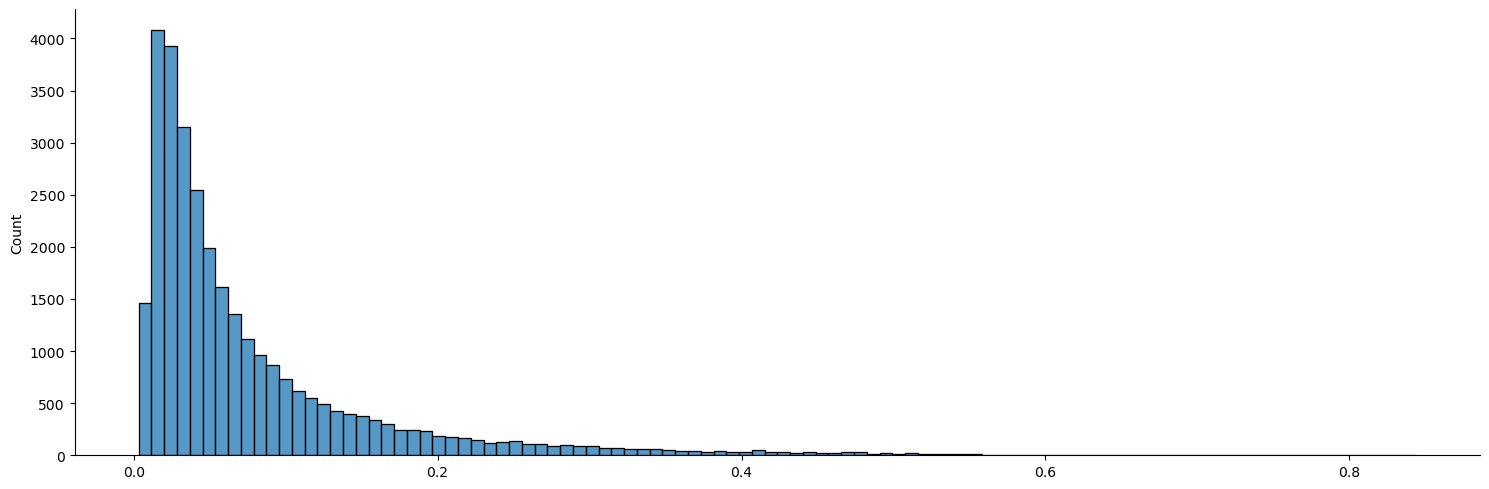

In [9]:
sns.displot(lgb_preds_test,kde=False,bins=100, height=5,aspect=3)

In [11]:
roc_auc_score(y_true=y_test,y_score=lgb_preds_test)

0.7869089418217567

In [12]:
from catboost import CatBoostClassifier,Pool
# CatBoost常用于处理类别特征效果明显
print(categorical_cols)
x_train_cat=x_train.copy()
x_test_cat=x_test.copy()
y_train_cat=y_train.copy()
cat_folds=list(kf.split(x_train_cat,y_train_cat))
cat_params = {
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'learning_rate': 0.02,
        'iterations': 3000,    # 迭代3000次
        'depth': 5,
        'l2_leaf_reg': 8,
        'random_seed': 108,
        'verbose': 500,         # 每 500 轮打印一次训练日志
        'early_stopping_rounds': 200,
        'allow_writing_files': False
    }
def train_catboost_oof(X,y,X_test,folds,cat_params,categorical_cols):
    cat_oof=np.zeros(len(X))
    preds_test = np.zeros(len(X_test))
    for fold, (train_idx, valid_idx) in enumerate(folds):
        print(f"Fold {fold+1}")

        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        train_pool = Pool(X_train, y_train,cat_features=categorical_cols)
        valid_pool = Pool(X_valid, y_valid,cat_features=categorical_cols)   
        test_pool  = Pool(X_test,cat_features=categorical_cols)          # CatBoost特殊的格式

        model = CatBoostClassifier(**cat_params)
        model.fit(train_pool,eval_set=valid_pool,use_best_model=True)
        modle_y_preds=model.predict_proba(valid_pool)[:,1]
        print("AUC是：")
        cat_auc=roc_auc_score(y_valid,modle_y_preds)
        print(cat_auc)
        cat_oof[valid_idx] = modle_y_preds
        preds_test += model.predict(test_pool) / len(folds)
    return cat_oof,preds_test

cat_oof,cat_preds_test=train_catboost_oof(X=x_train_cat,y=y_train_cat,X_test=x_test_cat,cat_params=cat_params,categorical_cols=categorical_cols,folds=cat_folds)


['FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_CONTRACT_TYPE_Cash_loans', 'NAME_CONTRACT_TYPE_Revolving_loans', 'CODE_GENDER_F', 'CODE_GENDER_M_and__Others__new__', 'FLAG_OWN_CAR_N', 'FLAG_OWN_CAR_Y', 'FLAG_OWN_REALTY_N', 'FLAG_OWN_REALTY_Y', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Others__new_', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_INCOME_TYPE_Commercial_associate', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State_servant_and__Others__new__', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher_education_and__Others__new__', 'NAME

In [14]:
roc_auc_score(y_test,cat_preds_test)

0.5297224209274095

In [13]:
# 在上述运行中发现如果只是对全部的数据集df进行统一的标签编码，然后再进行划分训练集与验证集，确实会解决问题。但是这时候出现了信息泄露的问题，因为这时候的标签编码是针对整个集而言的。
class RobustLabelEncoder:
    def __init__(self,min_obs=1):
        self.min_obs=min_obs
        self.mapper={}
        self.cate_dims = 0
    def fit(self,series):
        value_counts=series.value_counts()
        valid_cols=value_counts[value_counts>self.min_obs].index.tolist()
        # 构建映射表,从1开始映射
        self.mapper={val:i+1 for i,val in enumerate(valid_cols)}
        self.cate_dims=len(self.mapper)+1       # 记录类型标签的长度
        return self
    def transform(self,series):
        return series.map(self.mapper).fillna(0).astype(int).values   # 对于在fit中没有出现的类型，填充为0，这也就是为什么上面的fit是从i+1开始的
    def fit_transform(self,series):
        self.fit(series)
        return self.transform(series)

In [14]:
#scaler=StandardScaler()
# 这是对数值性特征进行的处理，也就是说不管是什么形式的分布，尤其是涉及到钱的右偏分布，都适合把这里变成正态分布。
scaler=QuantileTransformer(n_quantiles=2000,                 # 采样的份数，越大越精确，但容易过拟合。对于大这类数据，设为 2000 或 len(train) 都可以
                           output_distribution='normal',    # 变成高斯分布的关键
                           random_state=108)
x_train_numerical=x_train[numerical_cols].copy()
x_test_numerical=x_test[numerical_cols].copy()
for col in numerical_cols:   # 防止某些数值性字段出现无穷大的，就没有办法进行标签编码
    x_train_numerical[col] = x_train_numerical[col].replace([np.inf, -np.inf], np.nan)
    x_test_numerical[col] = x_test_numerical[col].replace([np.inf, -np.inf], np.nan)
    if x_train_numerical[col].isnull().any():    #如果一列之中有缺失值存在
         # 创建一个新列标注是否缺失
         x_train_numerical[f"{col}_is_NaN"]=x_train_numerical[col].isnull().astype(int)  # astype()可以把bool值变成数字1，0
         x_test_numerical[f"{col}_is_NaN"]=x_test_numerical[col].isnull().astype(int) 
         # 此时对缺失值进行填充。用中位数填充会忽略到不填收入的人的违约风险，所以在填充前进行人员的标注
         med = x_train_numerical[col].median()
         if pd.isna(med):
             med=0
         x_train_numerical[col] = x_train_numerical[col].fillna(med)
         x_test_numerical[col] = x_test_numerical[col].fillna(med)

x_train_numerical = scaler.fit_transform(x_train_numerical)  # 返回的是numpy的格式
x_test_numerical  = scaler.transform(x_test_numerical)

# 对非数值性特征进行处理
cate_dims_ls=[]
valid_categorical_cols = [] 
x_train_cate_encoded = x_train[categorical_cols].copy()
x_test_cate_encoded = x_test[categorical_cols].copy()
for col in categorical_cols:
     x_train_cate_encoded[col]=x_train_cate_encoded[col].fillna("MISSING_VAL").astype(str)
     x_test_cate_encoded[col]=x_test_cate_encoded[col].fillna("MISSING_VAL").astype(str)
     encoder=RobustLabelEncoder(min_obs=1)
     encoder.fit(x_train_cate_encoded[col])
    #在训练集和测试集上 TRANSFORM
    # 关键点：如果 x_test 里出现了 x_train 里没有的类别，会自动变为 0
     x_train_cate_encoded[col] = encoder.transform(x_train_cate_encoded[col])
     x_test_cate_encoded[col] = encoder.transform(x_test_cate_encoded[col])
     max_index_train =x_train_cate_encoded[col].max()
     max_index_test=x_test_cate_encoded[col].max()
     num_embeddings = max(int(max_index_train),int(max_index_test)) + 1
     #print(f"{col}_dim_{num_embeddings}")
     if num_embeddings>100 or num_embeddings==1:
          continue
     cate_dims_ls.append(num_embeddings)
     valid_categorical_cols.append(col)
print("分类特征维度:", cate_dims_ls)
print("分类特征数量:", len(cate_dims_ls))

# 设置每个类别特征的嵌入维度（这是一个超参数）
# 经验法则: emb_dim = min(50, (cardinality + 2) // 2)
emb_dims = [(x, min(50, (x + 2) // 2)) for x in cate_dims_ls]

分类特征维度: [3, 3, 3, 15, 4, 25, 3, 3, 3, 29, 8, 3, 3, 3, 5, 9, 10, 21, 10, 21, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 40, 27, 11, 31, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 9, 9, 3, 27, 4, 3, 22, 4, 3, 3, 8, 4, 3, 3, 46, 3, 47, 3, 3, 3, 44, 3, 8, 3]
分类特征数量: 102


In [15]:
import torch
import torch.nn as nn

# 1. 定义 Swap Noise (核心组件)
class SwapNoise(nn.Module):
    def __init__(self, probability=0.15):  # 这里的0.15是说Batch
        super().__init__()
        self.probability = probability

    def forward(self, x):
        if not self.training:
            return x
        # 生成掩码：1代表保持，0代表交换
        # torch.full_like(x, 1 - self.probability)生成了和x形状完全一样的全为0.85的张量
        mask = torch.bernoulli(torch.full_like(x, 1 - self.probability))
        
        # 在 Batch 内部随机打乱样本顺序
        batch_size = x.size(0)
        # torch.randperm(n)`：返回 `[0, 1, ..., n-1]` 的一个随机排列
        idx = torch.randperm(batch_size, device=x.device)
        shuffled_x = x[idx]
        
        # 混合：原数据 * 掩码 + 打乱数据 * (1-掩码)
        return x * mask + shuffled_x * (1 - mask)

# 2. 定义主模型（使用MLP）/使用ResNet呢，效果是如何的？？
class ResidualBlock(nn.Module):
    def __init__(self,input_dim,dropout=0.15):
        super().__init__()
        self.block=nn.Sequential(
            nn.Linear(input_dim,input_dim),nn.BatchNorm1d(input_dim),nn.PReLU(),
            nn.Dropout(dropout),
            nn.Linear(input_dim,input_dim),nn.BatchNorm1d(input_dim)
        )
        self.activation=nn.PReLU()

    def forward(self,x):
        return self.activation(x+self.block(x))
    
class DAE_MLP_Network(nn.Module):
    def __init__(self, num_numerical, emb_dims, hidden_dim=512, dropout=0.1,num_blocks=3):
        super().__init__()
        
        # --- A. Embedding 层  ---
        self.embedding_layers = nn.ModuleList([
            nn.Embedding(num, dim) for num, dim in emb_dims
        ])
        # 计算拼接后的总维度
        self.cat_dim = sum([dim for _, dim in emb_dims])
        self.total_dim = num_numerical + self.cat_dim
        
        # --- B. Swap Noise (只在预训练输入端使用) ---
        self.swap_noise = SwapNoise(probability=0.15)
        
        # --- C. Encoder (核心特征提取器) ---
        # 这是我们要预训练并迁移的部分
        # self.encoder = nn.Sequential(
        #     nn.Linear(self.total_dim, hidden_dim),nn.BatchNorm1d(hidden_dim),nn.PReLU(),
        #     nn.Dropout(dropout),
            
        #     nn.Linear(hidden_dim, hidden_dim),nn.BatchNorm1d(hidden_dim),nn.PReLU(),
        #     nn.Dropout(dropout),
            
        #     nn.Linear(hidden_dim, hidden_dim),nn.BatchNorm1d(hidden_dim),nn.PReLU(),
        #     #nn.Dropout(dropout),
        #     #nn.Linear(hidden_dim, hidden_dim),nn.BatchNorm1d(hidden_dim), nn.PReLU(),
        # )

        # 输入投影：先把维度映射到 hidden_dim
        self.input_proj = nn.Sequential(
            nn.Linear(self.total_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.PReLU()
        )
        #  堆叠残差块
        self.encoder = nn.Sequential(*[
            ResidualBlock(hidden_dim, dropout) for _ in range(num_blocks)
        ])

        
        # --- D. Decoder (只用于预训练) ---
        # 目标是还原回 total_dim 维度的原始输入
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, self.total_dim) 
        )
        
        # --- E. Classifier Head (只用于最终分类) ---
        self.classifier_head = nn.Sequential(
            nn.Linear(hidden_dim, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Linear(512, 1)
        )

    def forward_embeddings(self, x_categorical, x_numerical):
        embeddings=[]
        for i,emb_layer in enumerate(self.embedding_layers):
             embedding = emb_layer(x_categorical[:, i])
             embeddings.append(embedding)
        # 将所有嵌入向量在特征维度上(dim=1)拼接起来
        categorical_data = torch.cat(embeddings, 1)
        # 将原始的数值特征和拼接好的类别嵌入向量再次拼接
        x_combined = torch.cat([x_numerical, categorical_data], 1)   # 形状为(1024,552)
        return x_combined  
    
    def forward_pretrain(self, x_cat, x_num):
        """预训练时的前向传播"""
        # 1. 获取干净的输入 (Clean Input)
        clean_input = self.forward_embeddings(x_cat, x_num)
        
        # 2. 加噪声 (Noisy Input)
        noisy_input = self.swap_noise(clean_input)
        
        # 3. 编码 (Encoder)
        #latent_feat = self.encoder(noisy_input)   # 这是MLP的编码方式
        x = self.input_proj(noisy_input)
        latent_feat = self.encoder(x)

        # 4. 解码 (Decoder)
        reconstruction = self.decoder(latent_feat)
        
        return reconstruction, clean_input

    def forward_classify(self, x_cat, x_num):
        """微调/推理时的前向传播"""
        # 1. 获取干净输入 (此时不加噪声！)
        clean_input = self.forward_embeddings(x_cat, x_num)
        
        # 2. 编码
        #latent_feat = self.encoder(clean_input)     # # 这是MLP的编码方式
        x = self.input_proj(clean_input)
        latent_feat = self.encoder(x)

        # 3. 分类
        logits = self.classifier_head(latent_feat)
        return logits,latent_feat

In [16]:
x_train_numerical_df=pd.DataFrame(scaler.fit_transform(x_train_numerical),columns=numerical_cols)
x_test_numerical_df =pd.DataFrame(scaler.transform(x_test_numerical),columns=numerical_cols)

In [17]:
num_numerical_features=len(numerical_cols)
print(y_train)
if isinstance(y_train,np.ndarray):
    y_train=pd.Series(y_train.flatten())
y_train = y_train.values.astype('float32').reshape(-1, 1)  # 用于 BCE loss..这样y_train就是[n_samples,1]
X_train_num_tensor = torch.tensor(x_train_numerical, dtype=torch.float32)
X_train_cate_tensor = torch.tensor(x_train_cate_encoded[valid_categorical_cols].values, dtype=torch.long)     # 嵌入层的输入对于分类特征必须是torch.long的格式
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
train_dataset=TensorDataset(X_train_num_tensor,X_train_cate_tensor,y_train_tensor)         
train_loader=DataLoader(train_dataset,batch_size=1024,shuffle=True)

y_test = y_test.values.astype('float32').reshape(-1, 1)  # 用于 BCE loss
X_test_num_tensor = torch.tensor(x_test_numerical, dtype=torch.float32)
X_test_cate_tensor= torch.tensor(x_test_cate_encoded[valid_categorical_cols].values,dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
test_dataset=TensorDataset(X_test_num_tensor,X_test_cate_tensor,y_test_tensor)         
test_loader=DataLoader(test_dataset,batch_size=1024,shuffle=False)

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

213080    0
224440    0
148283    0
56155     0
7812      0
         ..
3461      0
4792      0
101428    0
126394    0
114578    0
Name: TARGET, Length: 276759, dtype: int64


In [18]:
# 初始化模型
num_numerical_features=len(numerical_cols)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DAE_MLP_Network(num_numerical=num_numerical_features, emb_dims=emb_dims).to(device)
# 专门的优化器
pretrain_optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
# 损失函数是 MSE (均方误差)，用于衡量还原得像不像
pretrain_criterion = nn.MSELoss()
print("🚀 开始 DAE 预训练...")
EPOCHS_PRETRAIN = 16
loss_history=[]
for epoch in range(EPOCHS_PRETRAIN):
    model.train()
    total_loss = 0
    
    # 遍历 DataLoader (这里的 y 在预训练中没用)
    for x_num, x_cat, _ in train_loader:
        x_num, x_cat = x_num.to(device), x_cat.to(device)    
        # 前向传播 (预训练模式)
        # 输出：重建的向量，原始干净向量
        reconstruction, clean_target = model.forward_pretrain(x_cat, x_num)
        # 计算 Loss：模型学到的特征和真实特征之间的差值
        loss = pretrain_criterion(reconstruction, clean_target)
        pretrain_optimizer.zero_grad()
        loss.backward()
        pretrain_optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Pretrain Epoch {epoch+1}/{EPOCHS_PRETRAIN} | MSE Loss: {avg_loss:.6f}")
torch.save(model.state_dict(),"pretrain_dae.pth")
print("✅ DAE 预训练完成！模型已经学会了数据的内部结构。")

🚀 开始 DAE 预训练...
Pretrain Epoch 1/16 | MSE Loss: 2.112354
Pretrain Epoch 2/16 | MSE Loss: 0.832968
Pretrain Epoch 3/16 | MSE Loss: 0.625499
Pretrain Epoch 4/16 | MSE Loss: 0.529122
Pretrain Epoch 5/16 | MSE Loss: 0.468464
Pretrain Epoch 6/16 | MSE Loss: 0.426342
Pretrain Epoch 7/16 | MSE Loss: 0.395597
Pretrain Epoch 8/16 | MSE Loss: 0.371202
Pretrain Epoch 9/16 | MSE Loss: 0.351399
Pretrain Epoch 10/16 | MSE Loss: 0.334072
Pretrain Epoch 11/16 | MSE Loss: 0.320388
Pretrain Epoch 12/16 | MSE Loss: 0.307315
Pretrain Epoch 13/16 | MSE Loss: 0.296293
Pretrain Epoch 14/16 | MSE Loss: 0.286351
Pretrain Epoch 15/16 | MSE Loss: 0.277291
Pretrain Epoch 16/16 | MSE Loss: 0.268945
✅ DAE 预训练完成！模型已经学会了数据的内部结构。


d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


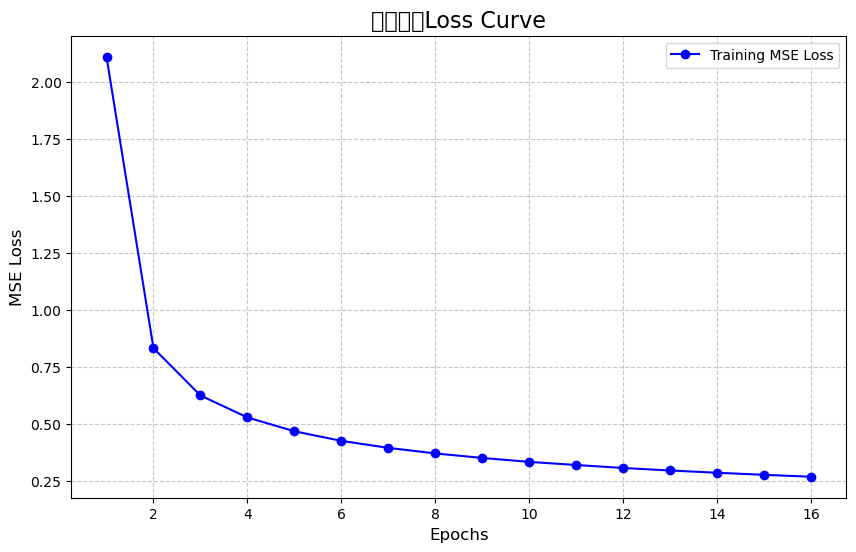

In [19]:
# 设置画布大小
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS_PRETRAIN + 1), loss_history, marker='o', linestyle='-', color='b', label='Training MSE Loss')
# 添加标题和标签
plt.title('预训练的Loss Curve', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [20]:
def train_each_epoch(model,train_loader,device,loss,optimizer,auc_metric):
    metrics = {
        'loss': 0.0,
        'samples': 0,
    }
    model.train()         # 切换为训练模式
    # 在每个 epoch 开始时，重置 metric 的内部状态
    auc_metric.reset()
    for X_num,X_cate,y in train_loader:
        X_num,X_cate, y = X_num.to(device), X_cate.to(device),y.to(device)
        y_hat,_=model.forward_classify(X_cate,X_num)
        l=loss(y_hat,y)   # 因为nn.BCEWithLogitsLoss()默认返回的是平均损失，所以要算总损失还要用  l*样本数

        # 更新过程
        optimizer.zero_grad()
        l.backward()
        optimizer.step() #更新权重
        
        batch_size=y.numel()                        # 也可以使用y.size(0)
        metrics["loss"] += l.item()*batch_size      # l.item()返回的是一个python的数值
        metrics["samples"] +=y.numel()

         # (新增) 更新AUC metric
        # .update() 会累计每个批次的结果
        # 注意：torchmetrics 需要整数标签，所以用 .int()
        auc_metric.update(y_hat,y.int())
    metrics["auc"]  = auc_metric.compute().item()
    return metrics
def eval_each_epoch(model,test_loader,device,loss,auc_metric):
    metrics = {
        'loss': 0.0,
        'samples': 0
    }
    model.eval()       # 切换为评估模式
    auc_metric.reset()
    with torch.no_grad():
        for X_num,X_cate,y in test_loader:
            X_num,X_cate, y = X_num.to(device), X_cate.to(device),y.to(device)
            y_hat,latent_val=model.forward_classify(X_cate,X_num)
            l=loss(y_hat,y)   # 因为nn.BCEWithLogitsLoss()默认返回的是平均损失，所以要算总损失还要用  l*样本数
            batch_size=y.size(0)
            metrics["loss"] += l.item()*batch_size      # l.item()返回的是一个python的数值
            metrics["samples"] +=y.numel()
            auc_metric.update(y_hat,y.int())
    metrics["auc"]  = auc_metric.compute().item()
    return metrics


def train_epoches(model,train_loader,test_loader,device,loss,optimizer,epoches=20):
    train_auc_metric = BinaryAUROC().to(device)
    val_auc_metric = BinaryAUROC().to(device)
    patience = 5 
    patience_counter=0
    best_val_auc=float('-inf')
    eval_auc_epoches=[]
    for epoch in range(epoches):
        train_metrics = train_each_epoch(model,train_loader,device,loss,optimizer,auc_metric=train_auc_metric)
        eval_metrics  = eval_each_epoch(model,test_loader,device,loss,auc_metric=val_auc_metric)
        avg_loss=train_metrics['loss'] / train_metrics['samples']
        train_auc=train_metrics["auc"]

        eval_avg_loss = eval_metrics['loss'] / eval_metrics['samples']
        eval_auc=eval_metrics["auc"]
        eval_auc_epoches.append(eval_auc)

        if eval_auc>best_val_auc:
            best_val_auc=eval_auc
            print(f"保存的是第{epoch}轮的模型")
            torch.save(model.state_dict(),'best_model.pth')
            print(f"Epoch {epoch}: New best model saved with Val AUC: {eval_auc:.4f},,,,,{best_val_auc:.4f}")
            patience_counter = 0 # 重置耐心计数器
        else:
            patience_counter +=1
        if patience_counter >=patience:
            print(f"模型在第{epoch-5}轮中接下来持续{patience}轮无法做到AUC更好，停止模型的训练")
            #break
    return model,eval_auc_epoches
# 重新初始化优化器 (这是微调的关键，学习率通常比预训练小一点，或者结合 OneCycleLR)
#finetune_optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# 分类损失函数
#criterion = nn.BCEWithLogitsLoss() 
#train_epoches(model=model,train_loader=train_loader,test_loader=test_loader,device=device,loss=criterion,optimizer=finetune_optimizer,epoches=20)

=== NN Fold 1 ===
276755
保存的是第0轮的模型
Epoch 0: New best model saved with Val AUC: 0.7554,,,,,0.7554
保存的是第1轮的模型
Epoch 1: New best model saved with Val AUC: 0.7587,,,,,0.7587
保存的是第3轮的模型
Epoch 3: New best model saved with Val AUC: 0.7612,,,,,0.7612
在验证集上的AUC变化过程


d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missin

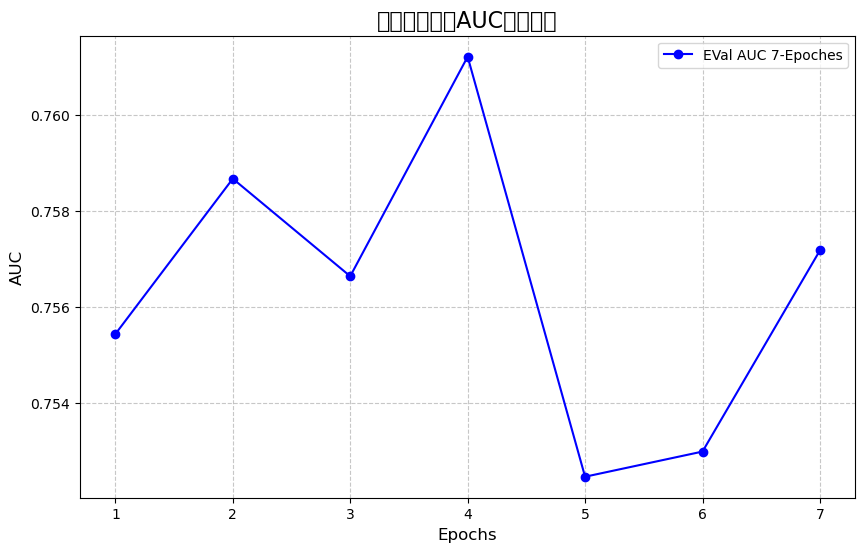

=== NN Fold 2 ===
276750
保存的是第0轮的模型
Epoch 0: New best model saved with Val AUC: 0.7499,,,,,0.7499
保存的是第1轮的模型
Epoch 1: New best model saved with Val AUC: 0.7606,,,,,0.7606
模型在第1轮中接下来持续5轮无法做到AUC更好，停止模型的训练
在验证集上的AUC变化过程


d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missin

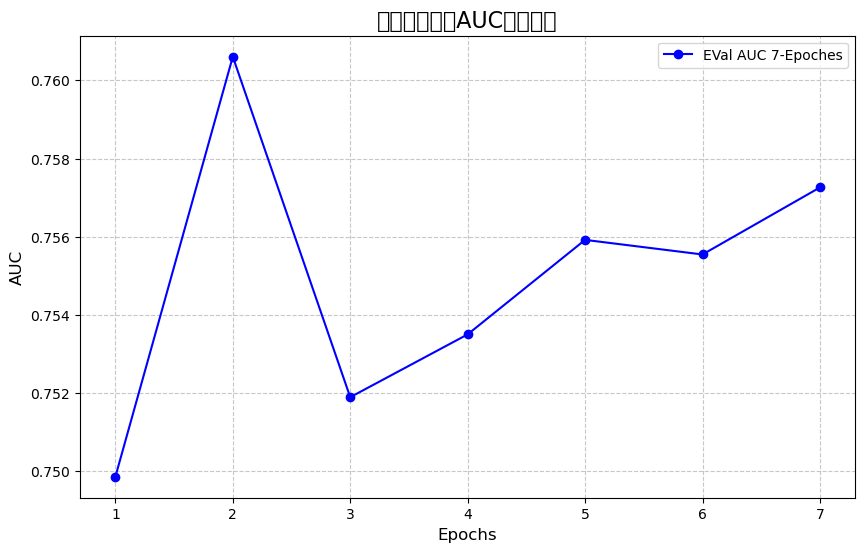

=== NN Fold 3 ===
276758
保存的是第0轮的模型
Epoch 0: New best model saved with Val AUC: 0.7433,,,,,0.7433
保存的是第1轮的模型
Epoch 1: New best model saved with Val AUC: 0.7528,,,,,0.7528
保存的是第3轮的模型
Epoch 3: New best model saved with Val AUC: 0.7547,,,,,0.7547
保存的是第4轮的模型
Epoch 4: New best model saved with Val AUC: 0.7556,,,,,0.7556
在验证集上的AUC变化过程


d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missin

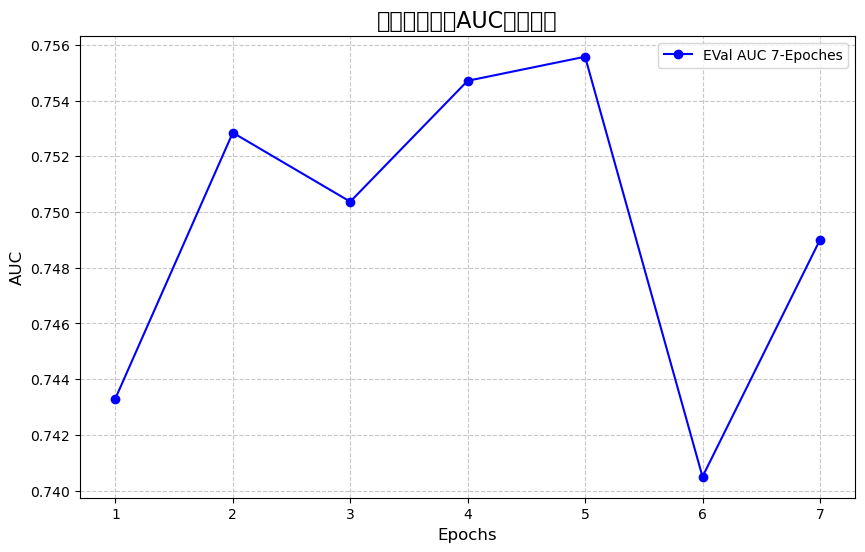

=== NN Fold 4 ===
276743
保存的是第0轮的模型
Epoch 0: New best model saved with Val AUC: 0.7504,,,,,0.7504
保存的是第1轮的模型
Epoch 1: New best model saved with Val AUC: 0.7567,,,,,0.7567
保存的是第2轮的模型
Epoch 2: New best model saved with Val AUC: 0.7592,,,,,0.7592
在验证集上的AUC变化过程


d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missin

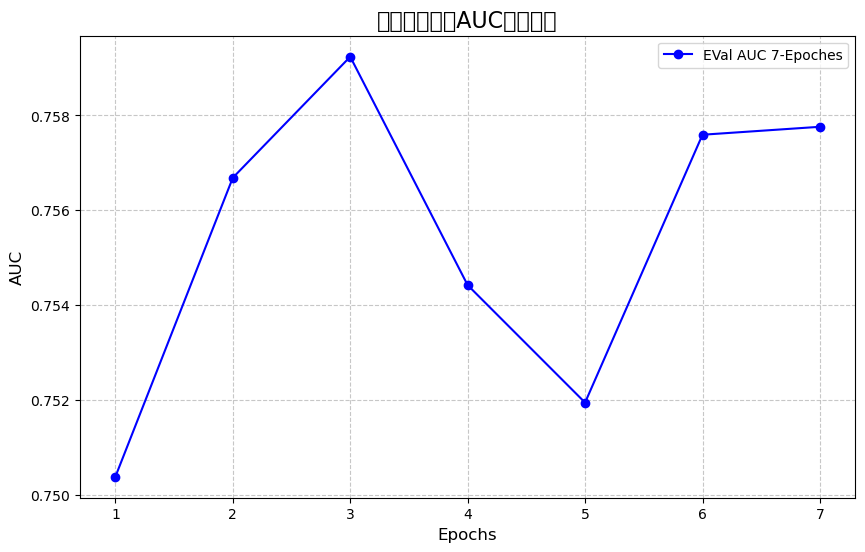

=== NN Fold 5 ===
276757
保存的是第0轮的模型
Epoch 0: New best model saved with Val AUC: 0.7500,,,,,0.7500
保存的是第1轮的模型
Epoch 1: New best model saved with Val AUC: 0.7543,,,,,0.7543
保存的是第2轮的模型
Epoch 2: New best model saved with Val AUC: 0.7582,,,,,0.7582
保存的是第4轮的模型
Epoch 4: New best model saved with Val AUC: 0.7640,,,,,0.7640
在验证集上的AUC变化过程


d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MiniConda\envs\jupyterbook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missin

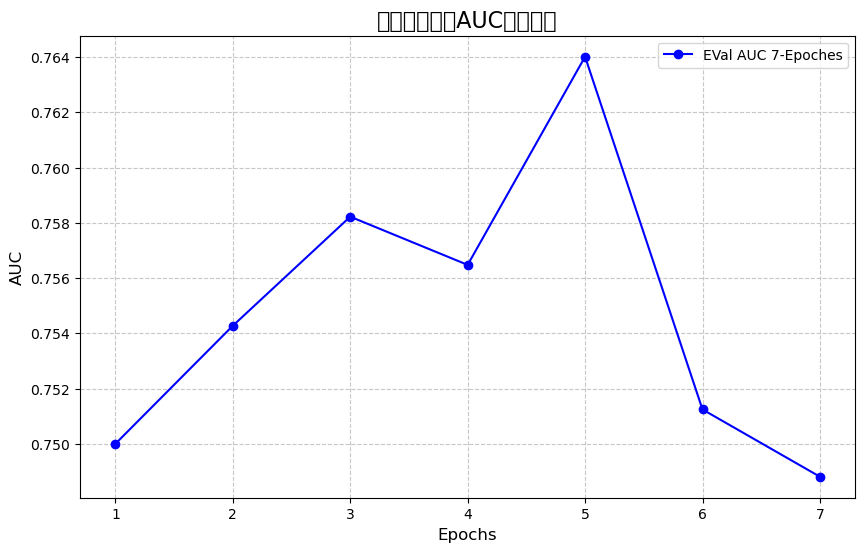

In [21]:
# 下面进行5折分层神经网络训练
from sklearn.model_selection import StratifiedKFold
kf=StratifiedKFold(n_splits=5,random_state=108,shuffle=True)
nn_folds=list(kf.split(x_train_numerical,y_train))

def train_NN_oof(x_train_numerical, x_train_cate_encoded, y_train,x_test_numerical,x_test_cate_encoded, y_test,folds):
    if isinstance(y_train,pd.Series):
        y_train=y_train.values
    oof = np.zeros(len(y_train))
    oof_latents = np.zeros((len(y_train), 512), dtype=np.float32)
    # 用于测试集的部分
    test_latents_all=np.zeros((len(x_test_numerical), 512), dtype=np.float32)
    preds_test = np.zeros(len(x_test_numerical))
     # 在最佳模型预测下进行
    y_test = y_test.astype('float32').reshape(-1, 1)  # 用于 BCE loss
    X_test_num_tensor = torch.tensor(x_test_numerical, dtype=torch.float32)
    X_test_cate_tensor= torch.tensor(x_test_cate_encoded[valid_categorical_cols].values,dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    test_dataset=TensorDataset(X_test_num_tensor,X_test_cate_tensor,y_test_tensor)         
    test_loader=DataLoader(test_dataset,batch_size=1024,shuffle=False)

    for fold, (train_idx, valid_idx) in enumerate(folds):
        print(f"=== NN Fold {fold+1} ===")
        print(valid_idx.max()) 
        y_train_idx = y_train[train_idx].astype('float32').reshape(-1, 1)                # 用于 BCE loss..这样y_train就是[n_samples,1]
        X_train_num_tensor_idx = torch.tensor(x_train_numerical[train_idx], dtype=torch.float32)
        X_train_cate_tensor_idx = torch.tensor(x_train_cate_encoded[valid_categorical_cols].values[train_idx], dtype=torch.long)     # 嵌入层的输入对于分类特征必须是torch.long的格式
        y_train_tensor_idx = torch.tensor(y_train_idx, dtype=torch.float32)
        train_dataset_idx=TensorDataset(X_train_num_tensor_idx,X_train_cate_tensor_idx,y_train_tensor_idx)         
        train_loader_idx=DataLoader(train_dataset_idx,batch_size=1024,shuffle=True)


        y_val_idx = y_train[valid_idx].astype('float32').reshape(-1, 1)  # 用于 BCE loss
        X_val_num_tensor_idx = torch.tensor(x_train_numerical[valid_idx], dtype=torch.float32)
        X_val_cate_tensor_idx= torch.tensor(x_train_cate_encoded[valid_categorical_cols].values[valid_idx],dtype=torch.long)
        y_val_tensor_idx = torch.tensor(y_val_idx, dtype=torch.float32)
        val_dataset_idx=TensorDataset(X_val_num_tensor_idx,X_val_cate_tensor_idx,y_val_tensor_idx)         
        val_loader_idx=DataLoader(val_dataset_idx,batch_size=1024,shuffle=False)
        
        # 分类损失函数
        criterion = nn.BCEWithLogitsLoss() 
        model.load_state_dict(torch.load('pretrain_dae.pth'), strict=False)

        # 使用预训练的过程进行初始化权重,这时候要把除了classifier_head的给锁住，也就是不能进行反向传播了
        for name,param in model.named_parameters():
            if "classifier_head" not in name:
                param.requires_grad=False
        first_optimizer=torch.optim.AdamW(filter(lambda x:x.requires_grad,model.parameters()),lr=1e-4)
        model.train()
        for X_num,X_cate,y in train_loader_idx:
            X_num,X_cate, y = X_num.to(device), X_cate.to(device),y.to(device)
            y_hat,_=model.forward_classify(X_cate,X_num)
            l=criterion(y_hat,y)   # 因为nn.BCEWithLogitsLoss()默认返回的是平均损失，所以要算总损失还要用  l*样本数
            # 更新过程
            first_optimizer.zero_grad()
            l.backward()
            first_optimizer.step() #更新权重

        #  这时候再正式开始训练，评估
        for param in model.parameters():
            param.requires_grad = True
        finetune_optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
        best_model,eval_auc_epoches=train_epoches(model=model,train_loader=train_loader_idx,test_loader=val_loader_idx,device=device,loss=criterion,optimizer=finetune_optimizer,epoches=7)
        print("在验证集上的AUC变化过程")
                # 设置画布大小
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, 8),eval_auc_epoches , marker='o', linestyle='-', color='b', label='EVal AUC 7-Epoches')
        # 添加标题和标签
        plt.title('在验证集上的AUC变化过程', fontsize=16)
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel('AUC', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.show()


        best_model.eval()
        test_preds_fold=[]
        test_latents_fold=[]
        with torch.no_grad():
            # 验证集
            best_model.load_state_dict(torch.load("best_model.pth"),strict=False)
            best_preds,latent_val=best_model.forward_classify(X_val_cate_tensor_idx,X_val_num_tensor_idx)
            oof[valid_idx]=torch.sigmoid(best_preds).cpu().numpy().flatten()
            oof_latents[valid_idx] = latent_val.cpu().numpy()
            oof_latents_df=pd.DataFrame(oof_latents,columns=[f"latent_{i}" for i in range(oof_latents.shape[1])])
            # 测试集（分batch处理）
            for X_num,X_cate,y in test_loader:
                X_num,X_cate, y = X_num.to(device), X_cate.to(device),y.to(device)
                y_hat,latent_test=best_model.forward_classify(X_cate,X_num)
                test_preds_fold.append(torch.sigmoid(y_hat).cpu().numpy().flatten())  # flatten（）是用于把二维数组展平的操作  
                test_latents_fold.append(latent_test.cpu().numpy())
        test_latents_fold=np.vstack(test_latents_fold)
        test_preds_fold = np.concatenate(test_preds_fold)
        preds_test += test_preds_fold/5   # 需要对numpy才可以这样直接除以5
        test_latents_all +=test_latents_fold/5
        test_latents_df=pd.DataFrame(test_latents_all,columns=[f"latent_{i}" for i in range(test_latents_all.shape[1])])
    return oof,preds_test,oof_latents,test_latents_all

nn_oof,nn_preds_test,latents_val,latents_test=train_NN_oof(x_train_numerical, x_train_cate_encoded, y_train,x_test_numerical,x_test_cate_encoded,y_test, nn_folds)


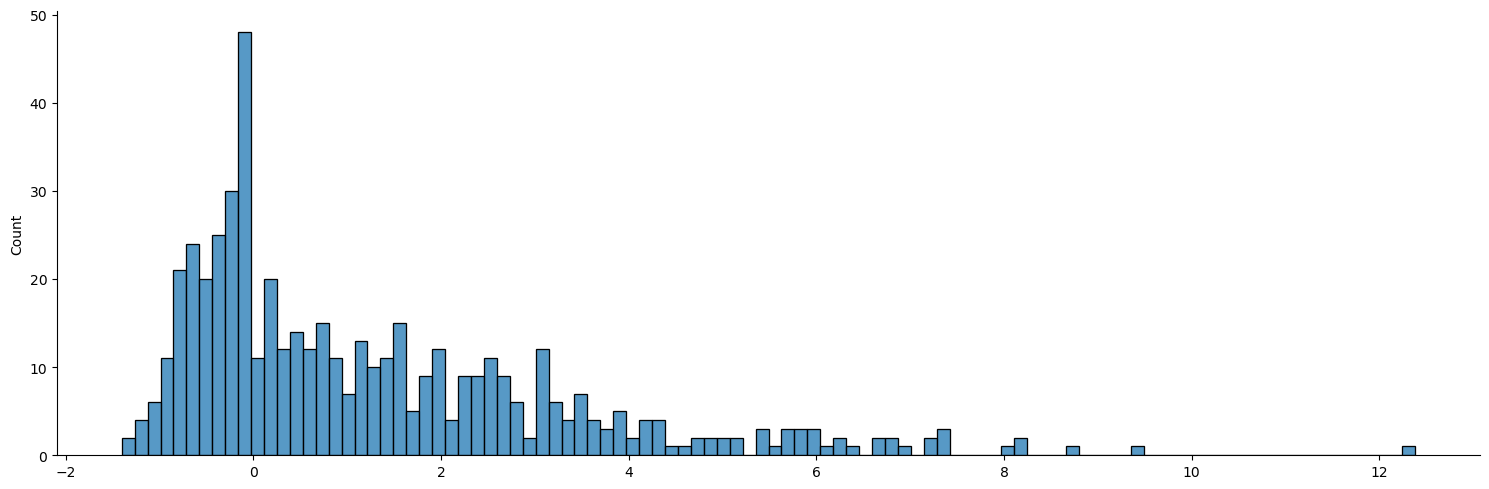

In [23]:
#nn_oof  #(276759,)
#nn_preds_test   #(30752,)
# lgb_oof      #(276759,)
# lgb_preds_test    #(30752,)
sns.displot(latents_val[1],kde=False, bins=100, height=5,aspect=3)

In [21]:
roc_auc_score(y_true=y_test,y_score=nn_preds_test)

0.7704991059726853

In [34]:
latents_val

array([[ 2.99053   , -0.03904284, -0.285112  , ...,  2.277646  ,
        -0.6547955 , -0.562642  ],
       [-0.33165795,  0.8445122 ,  0.48919487, ..., -0.5182472 ,
        -0.12382417,  0.70906925],
       [-0.27654132, -0.43305564,  1.1870116 , ...,  0.70680344,
         0.6521723 ,  1.2613132 ],
       ...,
       [ 1.338731  ,  1.1569592 ,  1.1012006 , ..., -0.10353386,
         2.5822167 ,  1.998934  ],
       [ 2.9655833 , -0.5146916 ,  0.8694565 , ...,  3.6295788 ,
        -0.7858163 , -0.05721651],
       [ 0.8579521 ,  1.3682158 ,  2.692359  , ...,  0.40403026,
         0.8861867 ,  1.4608613 ]], shape=(276759, 512), dtype=float32)

In [21]:
#  使用神经网络之后得到的潜在特征是否会对于预测有明显推进作用：检查与y_train的相关性，同时利用这一部分内容也可以进一步确定降维的数目
if isinstance(y_train,np.ndarray):
    y_train_1d=y_train.flatten()
    y_train_series = pd.Series(y_train_1d)
df_corr = pd.DataFrame(latents_val).corrwith(y_train_series)   # corrwith()仅支持pd.Series
print(df_corr.abs().sort_values(ascending=False).head(30))
top_15_latent_indices=df_corr.abs().sort_values(ascending=False).head(11).index
top_15_latent_indices


357    0.121060
506    0.120110
419    0.110336
0      0.110158
155    0.103669
228    0.102906
30     0.097950
233    0.097756
249    0.096993
176    0.096731
24     0.096339
431    0.096140
102    0.093435
317    0.092378
107    0.091821
193    0.090633
38     0.084603
255    0.081388
280    0.081322
222    0.080930
229    0.079753
150    0.079448
234    0.079098
106    0.079096
124    0.078683
356    0.078408
67     0.078404
341    0.077975
59     0.077315
216    0.075537
dtype: float64


Index([357, 506, 419, 0, 155, 228, 30, 233, 249, 176, 24], dtype='int64')

In [ ]:
latents_val_final=latents_val[:,top_15_latent_indices]
latents_val_final


array([[ 0.76112545, -0.36701944,  0.677712  , ...,  2.8961172 ,
         3.0150971 , -0.5425975 ],
       [ 0.30636382, -0.04629212,  1.1009212 , ...,  2.3941352 ,
        -0.9256278 , -0.38237974],
       [ 0.44461167,  3.5120397 ,  3.7507648 , ...,  0.6727916 ,
         0.28119195,  1.9677055 ],
       ...,
       [-0.32329243,  0.18292536,  0.9254285 , ...,  1.233633  ,
         3.0889719 , -0.1990286 ],
       [ 1.9322143 ,  0.22626722,  1.0840333 , ...,  0.7995329 ,
         0.07876325, -1.2318683 ],
       [-0.16435766,  0.77928007,  0.3834058 , ...,  2.704863  ,
         1.1066828 ,  4.045927  ]], shape=(276759, 30), dtype=float32)

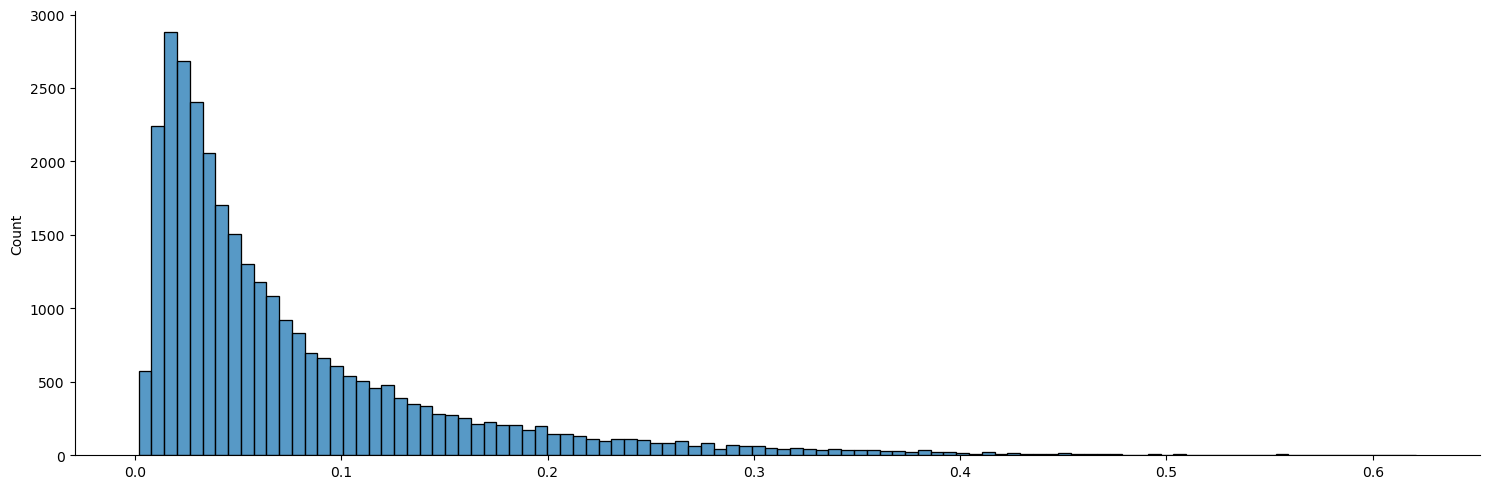

In [25]:
import seaborn as sns
sns.displot(nn_preds_test,kde=False, bins=100, height=5,aspect=3)

In [38]:
# 需要先对这里的潜在特征进行降维以及标准化
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#scaler_nn=StandardScaler()
# 这里的scaler是QuantileTransformer (RankGauss)标准化过程
scaler_nn = QuantileTransformer(output_distribution='normal', n_quantiles=2000, random_state=108)
latents_val=scaler_nn.fit_transform(latents_val)
latents_test=scaler_nn.transform(latents_test)

# 放弃这里的简单的降维
# pca_nn=PCA(n_components=11, random_state=108)
# latents_val_final=pca_nn.fit_transform(latents_val)
# latents_test_final=pca_nn.transform(latents_test)
latents_val_final=latents_val[:,top_15_latent_indices]
latents_test_final=latents_test[:,top_15_latent_indices]


x_train_aug=np.hstack([x_train_lgb.values,latents_val_final])
x_test_aug=np.hstack([x_test_lgb.values,latents_test_final])
x_train_aug_df=pd.DataFrame(x_train_aug)
x_test_aug_df=pd.DataFrame(x_test_aug)
latent_lgb_folds=list(kf.split(x_train_aug_df,y_train))

aug_lgb_params={
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.04,
    "num_leaves": 64,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "max_depth": -1,
    "min_data_in_leaf": 40,
    "lambda_l1": 1e-3,
    "lambda_l2": 1e-3,
    "verbosity": -1,
    "early_stopping_rounds":200,
    "verbose_eval":200
}
lgb_oof_2, lgb_test_preds_2 = train_lgb_oof(X=pd.DataFrame(x_train_aug), y=y_train, X_test=pd.DataFrame(x_test_aug), folds=latent_lgb_folds, lgb_params=aug_lgb_params)

Fold 1
AUC是：
0.7838920508507177
Fold 2
AUC是：
0.7795777590428616
Fold 3
AUC是：
0.7752661284332253
Fold 4
AUC是：
0.7765993481498478
Fold 5
AUC是：
0.7796286382837198


In [24]:
roc_auc_score(y_test,lgb_test_preds_2)

0.7871841301635728

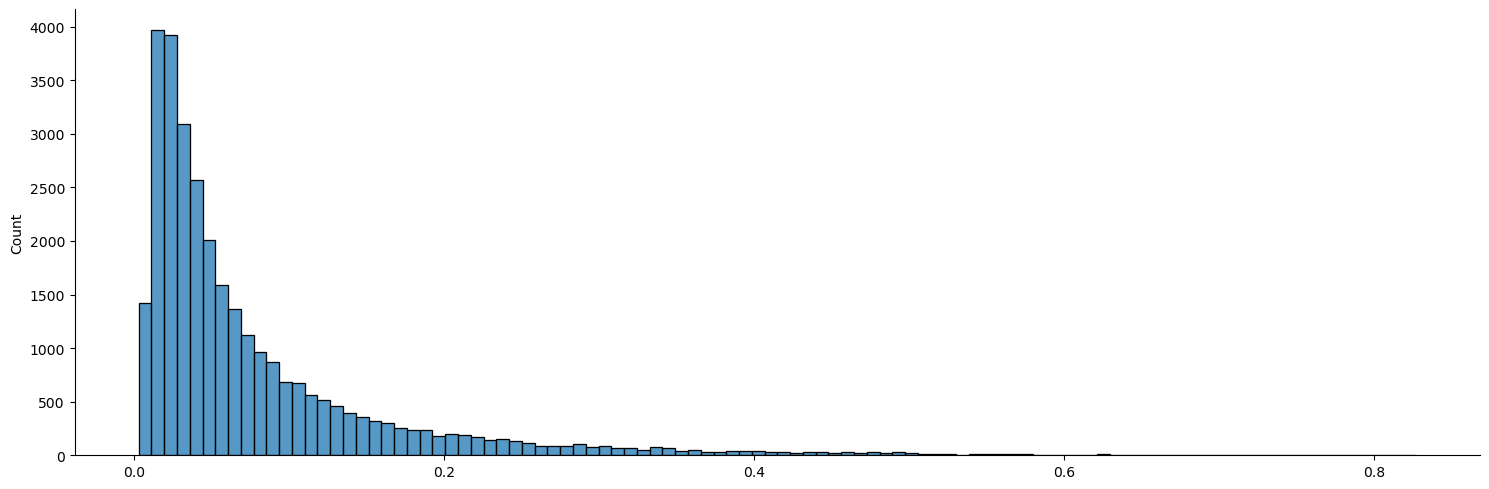

In [45]:
sns.displot(lgb_test_preds_2,kde=False,bins=100, height=5,aspect=3)

In [41]:
test_preds_series = pd.Series(lgb_test_preds_2)
test_preds_series

0        0.175061
1        0.027533
2        0.045130
3        0.009419
4        0.044475
           ...   
30747    0.025704
30748    0.146822
30749    0.026447
30750    0.062706
30751    0.008087
Length: 30752, dtype: float64

In [ ]:
# 现在想构造一个伪标签来添加进模型中
if isinstance(y_train,np.ndarray):
    y_train=pd.Series(y_train.flatten())

test_preds_series = pd.Series(lgb_test_preds_2)
# 选正样本 (High Confidence Positives)
pos_idx = test_preds_series[test_preds_series > 0.9].index
# 选负样本 (High Confidence Negatives) - 金融场景负样本多，阈值可以严一点
neg_idx = test_preds_series[test_preds_series < 0.05].index

print(f"筛选出伪标签数量: 正样本 {len(pos_idx)}, 负样本 {len(neg_idx)}")

# 提取这些数据
x_pseudo_pos = x_test_aug_df.iloc[pos_idx]
y_pseudo_pos = pd.Series(1, index=pos_idx) # 硬标签 1

x_pseudo_neg = x_test_aug_df.iloc[neg_idx]
y_pseudo_neg = pd.Series(0, index=neg_idx) # 硬标签 0

# 合并伪标签数据
x_pseudo_all = pd.concat([x_pseudo_pos, x_pseudo_neg])
y_pseudo_all = pd.concat([y_pseudo_pos, y_pseudo_neg])

pseudo_oof=np.zeros(len(x_train_aug_df))
pseudo_preds_test = np.zeros(len(x_test_aug_df))
for fold,(train_idx,val_idx) in enumerate(latent_lgb_folds):
    x_train_fold=x_train_aug_df.iloc[train_idx]
    y_train_fold=y_train[train_idx]

    x_val_fold=x_train_aug_df.iloc[val_idx]
    y_val_fold= y_train[val_idx]

    x_train_fold_aug=pd.concat([x_train_fold,x_pseudo_all],axis=0)
    y_train_fold_aug =pd.concat([y_train_fold,y_pseudo_all],axis=0)

    dtrain=lgb.Dataset(x_train_fold_aug,label=y_train_fold_aug)
    dval= lgb.Dataset(x_val_fold,label=y_val_fold, reference=dtrain)

    model = lgb.train(
            aug_lgb_params,
            dtrain,
            num_boost_round=5000,
            valid_sets=[dtrain, dval],  # 配合着early_stopping_rounds使用，实际可以只使用vaild_set作为早停检查的指标
            valid_names=["train", "valid"],
        )
    pred_y_vaild=model.predict(x_val_fold)
    print("AUC是：")
    lgb_auc=roc_auc_score(y_val_fold,pred_y_vaild)
    print(lgb_auc)
    pseudo_oof[val_idx] = pred_y_vaild
    pseudo_preds_test += model.predict(x_test_aug_df) / len(latent_lgb_folds)
roc_auc_score(y_test,pseudo_preds_test)

Fold 1
AUC是：
0.7838920508507177
Fold 2
AUC是：
0.7795777590428616
Fold 3


KeyboardInterrupt: 

In [ ]:
roc_auc_score(y_test,pseudo_preds_test)

0.7826544781994659

In [69]:
# 想通过KNN进行提取特征再去融合进x_train中
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA
def extract_KNN_features(X_train, y_train, X_test, n_neighbors=[500], n_pca=30):
    # 先进行(QuantileTransformer)标准化
    scaler=QuantileTransformer(output_distribution="normal",random_state=108)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)  

    pca = PCA(n_components=n_pca, random_state=108)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)  
    
    if isinstance(y_train, pd.Series):
        y_vals = y_train.values
    else:
        y_vals = y_train
    knn_features_train = np.zeros((len(X_train), len(n_neighbors)))
    knn_features_test = np.zeros((len(X_test), len(n_neighbors)))
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=108)
    KNN_folds=list(kf.split(X_train_pca,y_vals))
    for idx,k in enumerate(n_neighbors):
         # 训练集是邻居库，测试集是查询对象
        knn=NearestNeighbors(n_neighbors=k,n_jobs=-1)
        knn.fit(X_train_pca)
        # 找到测试集每个样本在训练集里的 k 个邻居
        # indices 形状 (N_test, k)
        _, indices = knn.kneighbors(X_test_pca)


        neighbors_targets = y_vals[indices]
        knn_features_test[:,idx]=neighbors_targets.mean(axis=1)

        #  # 做法：将训练集分成 5 折。用 4 折做库，查剩下的 1 折。
        for fold,(lib_idx,query_idx) in enumerate(KNN_folds):
            X_lib=X_train_pca[lib_idx]
            y_lib = y_vals[lib_idx]
            X_query=X_train_pca[query_idx]

            knn_fold=NearestNeighbors(n_neighbors=k,n_jobs=-1)
            knn_fold.fit(X_lib)
            _, indices_fold = knn_fold.kneighbors(X_query)
            neighbors_targets_fold=y_lib[indices_fold]
            knn_features_train[query_idx,idx]=neighbors_targets_fold.mean(axis=1)

    feature_names = [f'KNN_Target_Mean_{k}' for k in n_neighbors]
    print(knn_features_train)
    df_knn_train = pd.DataFrame(knn_features_train, columns=feature_names,index=X_train.index)
    df_knn_test = pd.DataFrame(knn_features_test, columns=feature_names,index=X_test.index)
    return df_knn_train,df_knn_test
            
        


In [74]:
X_train_knn=x_train.copy()
X_test_knn=x_test.copy()
y_train_knn=y_train.copy()
knn_train,knn_test=extract_KNN_features(X_train=X_train_knn,y_train=y_train_knn,X_test=X_test_knn,n_neighbors=[500],n_pca=64)

[[0.12 ]
 [0.058]
 [0.046]
 ...
 [0.08 ]
 [0.106]
 [0.072]]


In [75]:
print(x_train_lgb.shape)
y_train
print(knn_train.shape)
x_train_with_knn=pd.concat([x_train_lgb,knn_train],axis=1)
x_train_with_knn.shape

(276759, 538)
(276759, 1)


(276759, 539)

In [81]:
x_train_with_knn=pd.concat([x_train_aug_df,knn_train],axis=1)
x_test_with_knn=pd.concat([x_test_aug_df,knn_test],axis=1)
with_knn_lgb_folds=list(kf.split(x_train_with_knn,y_train))

with_knn_lgb_params={
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.04,
    "num_leaves": 64,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "max_depth": -1,
    "min_data_in_leaf": 40,
    "lambda_l1": 1e-3,
    "lambda_l2": 1e-3,
    "verbosity": -1,
    "early_stopping_rounds":200,
    "verbose_eval":200
}
lgb_oof_3, lgb_test_preds_3 = train_lgb_oof(X=x_train_with_knn,y=y_train, X_test=x_test_with_knn, folds=with_knn_lgb_folds, lgb_params=with_knn_lgb_params)

NameError: name 'x_test_aug_df' is not defined

In [82]:
roc_auc_score(y_test,lgb_test_preds_3)

0.7865972962959116

In [78]:
# 将多个数组在列方向上拼接（即“横向合并”
from sklearn.metrics import roc_auc_score
X_second_train = pd.DataFrame({
    "lgb": lgb_oof_3,
    "nn": nn_oof,
    #"cat":cat_oof
})

X_second_test = pd.DataFrame({
    "lgb": lgb_test_preds_3,
    "nn": nn_preds_test,
    #"cat":cat_preds_test
})
second_lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.02,
    "max_depth":5,
    "num_leaves": 8,
    "min_data_in_leaf": 6,
    "feature_fraction": 1.0,
    "bagging_fraction": 1.0,
    "lambda2":1.0,
    "verbosity": -1
}

second_folds=list(kf.split(X_second_train,y_train))
if isinstance(y_train,np.ndarray):
   y_train = pd.Series(y_train.flatten())
final_oof,final_preds_test=train_lgb_oof(X=X_second_train,y=y_train,X_test=X_second_test,folds=second_folds,lgb_params=second_lgb_params)
final_preds_test




Fold 1
AUC是：
0.7792427311278054
Fold 2
AUC是：
0.780413482555896
Fold 3
AUC是：
0.7701492514865919
Fold 4
AUC是：
0.7737050464364329
Fold 5
AUC是：
0.778037599942051


array([0.15997448, 0.02282609, 0.05053284, ..., 0.02723541, 0.04313156,
       0.00544412], shape=(30752,))

In [80]:
from sklearn.metrics import roc_auc_score

final_auc = roc_auc_score(y_test, final_preds_test)  # 使用 lgb_test_preds_3之后输出的final_preds_test的AUC是0.783，
print("Final Stacking AUC:", final_auc)

Final Stacking AUC: 0.7845899714364588


In [ ]:
#del nn_oof,nn_preds_test,lgb_oof,lgb_preds_test

In [ ]:
# 使用逻辑回归试一试嘛？
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(fit_intercept=True, solver='lbfgs')
lr.fit(X_second_train,y_train)
coefs=lr.coef_[0]
print(f"LR 分配的权重 -> LightGBM: {coefs[0]:.4f}, NN: {coefs[1]:.4f},Cat:{coefs[2]:.4f}")
train_preds=lr.predict_proba(X_second_train)[:,1]
test_preds=lr.predict_proba(X_second_test)[:,1]
lr_auc=roc_auc_score(y_true=y_test,y_score=test_preds)
lr_auc

LR 分配的权重 -> LightGBM: 2.8940, NN: 2.6295,Cat:2.9269


0.7848378489452214

In [96]:
from scipy.stats import rankdata
# 1. 确保你的预测值变量名是对的
# lgb_preds_test: LightGBM 对测试集的预测
# nn_preds_test:  神经网络 对测试集的预测
# cat_preds_test: CatBoost 对测试集的预测

# 2. 转换为排名 (0.0 ~ 1.0)
r_lgb = rankdata(aug_test_preds) / len(aug_test_preds)
r_nn  = rankdata(nn_preds_test) / len(nn_preds_test)
#r_cat = rankdata(cat_preds_test) / len(cat_preds_test)

# 3. 手动分配权重 (根据单模强弱)
# LGBM (0.789) 最强，Cat (0.78x) 次之，NN (0.766) 辅助
# 推荐比例: 0.5 : 0.3 : 0.2
final_rank_preds =1* r_lgb #+ 0.04 * r_nn # + 0.2* r_cat   # 0.78806

from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, final_rank_preds)
print(f"Rank Averaging (0.75/0.2/0.05) AUC: {score:.5f}")

Rank Averaging (0.75/0.2/0.05) AUC: 0.78725
